In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              BaggingClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier,
                              VotingClassifier,
                              StackingClassifier)
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, RocCurveDisplay, ConfusionMatrixDisplay, make_scorer
from sklearn.feature_selection import RFE
from sklearn.svm import SVC



import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
dataframe = pd.read_csv("E9WT_forclassification.csv")

display(dataframe.shape)
df= dataframe.copy()
columnas_eliminar = ["local_id_cells"]
df = df.drop(columns=columnas_eliminar, axis=1)
display(100*df.isnull().sum()/df.shape[0])
print()

num_valores_diferentes = df['Tbx5'].value_counts()

print("Número de valores diferentes en la columna 'Tbx5 ':", num_valores_diferentes)

df= df.dropna(subset=['theta1N', 'ratio_lambda'])
display(100*df.isnull().sum()/df.shape[0])
print(df.shape)

(8618, 14)

area_cells           0.000000
center_x_cells       0.000000
center_y_cells       0.000000
orientation_cells    0.000000
perimeter_length     0.000000
pressures            0.000000
theta1N              0.266883
ratio_lambda         0.266883
eccentricity         0.000000
n_neighbors          0.000000
Nb_embryo            0.000000
ATAN2                0.000000
Tbx5                 0.000000
dtype: float64


Número de valores diferentes en la columna 'Tbx5 ': Tbx5
0.0    7436
1.0    1182
Name: count, dtype: int64


area_cells           0.0
center_x_cells       0.0
center_y_cells       0.0
orientation_cells    0.0
perimeter_length     0.0
pressures            0.0
theta1N              0.0
ratio_lambda         0.0
eccentricity         0.0
n_neighbors          0.0
Nb_embryo            0.0
ATAN2                0.0
Tbx5                 0.0
dtype: float64

(8595, 13)


In [4]:
# Correlation matrix
corr_matrix = df.corr().round(2)

import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

* Separating labels from features

In [5]:
print("Separating labels from features...")

target_variable = "Tbx5"

X = df.drop(target_variable, axis=1)
y = df.loc[:, target_variable]

print("...Done.")
print()

print("Y : ")
print(y.head())
print()
print("X :")
print(X.head())

print()

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,  stratify=y)
print("...Done.")
print()

Separating labels from features...
...Done.

Y : 
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: Tbx5, dtype: float64

X :
   area_cells  center_x_cells  center_y_cells  orientation_cells  \
1         122       24.975410      817.786885           2.049571   
2         869       33.761795      842.621404           1.791812   
3         856       37.967290      664.415888           2.011333   
4         662       37.105740      978.809668           1.919752   
5         303       33.696370      626.224422           1.700303   

   perimeter_length  pressures   theta1N  ratio_lambda  eccentricity  \
1         51.213203   0.019273  0.753534      0.107335      0.543217   
2        142.852814  -0.008199  0.128907      0.658197      0.260831   
3        140.468037  -0.035611  0.133679      0.393390      0.943897   
4        132.124892   0.013451 -0.130873      0.218346      0.806600   
5         76.183766  -0.034522  0.196935      0.676989      0.344984   

   n_neighbors  Nb_embryo  ATAN

In [6]:
numeric_features =["center_x_cells",	"center_y_cells",	"orientation_cells", "perimeter_length",	"pressures",	"theta1N",	"Nb_embryo"]
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

X_train = preprocessor.fit_transform(X_train)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

print(X_train[0:5], y_train[0:6])

X_test = preprocessor.transform(X_test)
y_test= encoder.transform(y_test)

print(X_test[0:5], y_test[0:20])

[[-0.89052515 -0.45543806  1.47402184 -1.53081619  4.01613479  1.37674347
   0.91646807]
 [-1.37043837  0.6906575   0.63172694 -0.49718744 -0.31288272  0.63731084
   0.91646807]
 [-0.56816433  0.6044695   1.37087443 -0.11828045  0.33486868  0.90066981
   0.35246248]
 [-1.06131072 -0.61469451  0.70573727 -0.18002368  0.3580527   0.58171494
   0.91646807]
 [-1.11299055 -1.23095345 -1.07788863  0.22716461  0.02781915 -1.41784254
  -0.7755487 ]] [0 0 0 0 0 0]
[[-0.35356174 -0.50184007  0.97553462  0.51740027 -0.4369545   1.20576352
  -1.33955429]
 [ 1.27272415 -1.02278944  1.64173666 -1.15652933 -1.02649435  1.27930216
  -1.33955429]
 [-1.63685028  0.8230732   0.73967815  0.23696538 -0.12068765  0.55604294
  -1.33955429]
 [ 0.0939264  -1.05916767 -1.50457188 -0.65413586  2.44769082 -1.67313606
  -1.33955429]
 [ 0.32859655 -0.29690235 -0.33390431  1.32445032 -0.34871628 -0.45385289
  -0.7755487 ]] [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


#GradientBoosting
* Boosting with decision tree as base estimator

In [7]:
# Perform grid search
print("Grid search...")
model = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    "max_depth": [
        1,
        2,
        3,
    ],  # no base_estimator_ prefix because these are all arguments of GradientBoostingClassifier
    "min_samples_leaf": [1, 2, 3],
    "min_samples_split": [2, 3, 4],
    "n_estimators": [2, 4, 6, 8, 10],
}
print(params)
gridsearch = GridSearchCV(
    model, param_grid=params, cv=3
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, y_test))

Grid search...
{'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best validation accuracy :  0.933391506689936

Accuracy on training set :  0.9413903432228039
Accuracy on test set :  0.9383362420011635


In [8]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = gridsearch.predict(X_train)
print("...Done.")
print(y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
y_train_proba = gridsearch.predict_proba(X_train)
print("...Done.")
print(y_train_proba)
print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = gridsearch.predict(X_test)
print("...Done.")
print(y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
y_test_proba = gridsearch.predict_proba(X_test)
print("...Done.")
print(y_test_proba)
print()


# Print scores
print("accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("accuracy on test set : ", accuracy_score(y_test, y_test_pred))
print()

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 1]

Probabilities on training set...
...Done.
[[0.94803856 0.05196144]
 [0.93486406 0.06513594]
 [0.75204098 0.24795902]
 ...
 [0.91936711 0.08063289]
 [0.94803856 0.05196144]
 [0.40440183 0.59559817]]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 1]

Probabilities on test set...
...Done.
[[0.94803856 0.05196144]
 [0.94803856 0.05196144]
 [0.93594822 0.06405178]
 ...
 [0.94803856 0.05196144]
 [0.91811719 0.08188281]
 [0.40440183 0.59559817]]

accuracy on training set :  0.9413903432228039
accuracy on test set :  0.9383362420011635

f1-score on training set :  0.7630805408583187
f1-score on test set :  0.7523364485981308



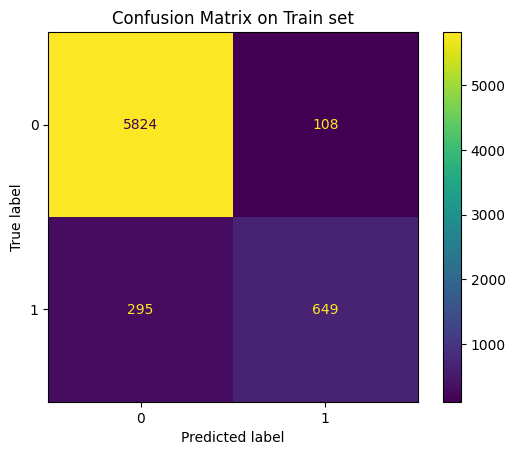

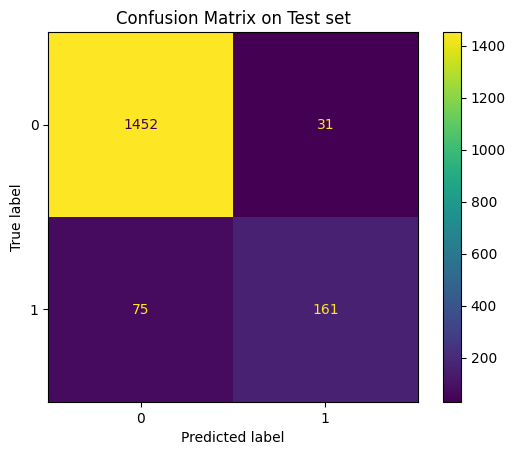

In [9]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()